In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
import lightgbm as lgb

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
test_ID = data_test['Id']
data_train.drop("Id", axis = 1, inplace = True)
data_test.drop("Id", axis = 1, inplace = True)

In [3]:
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
corr = data_train.corr()['SalePrice']

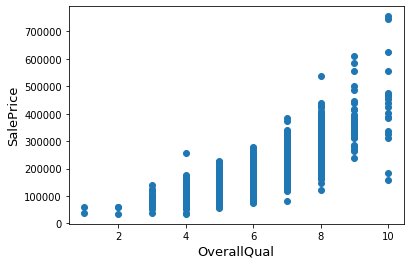

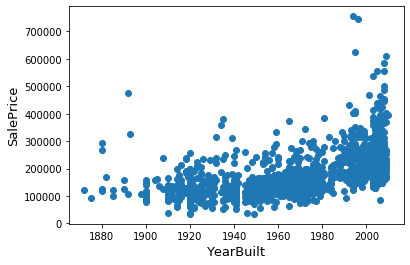

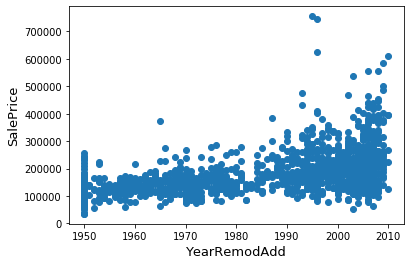

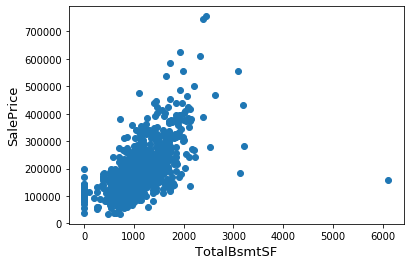

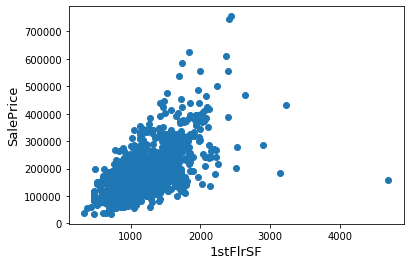

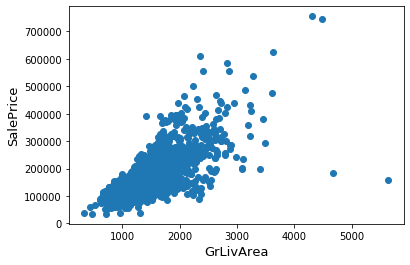

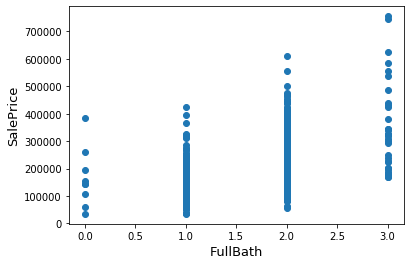

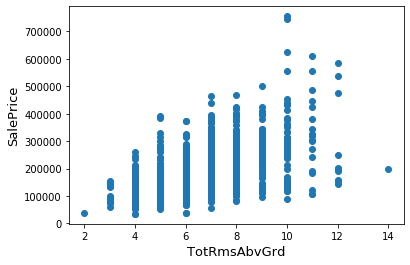

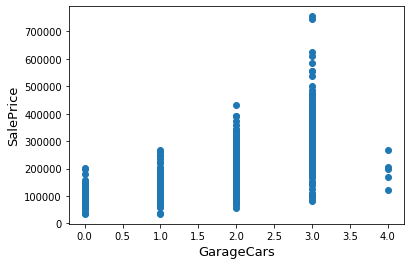

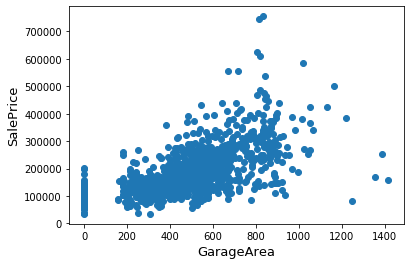

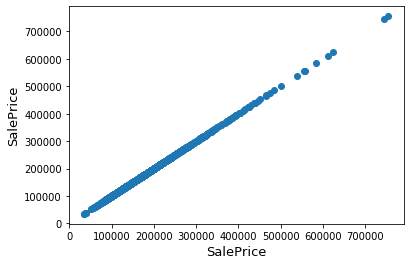

In [5]:
for column in corr.keys():
    if corr[column] > 0.5:
        fig, ax = plt.subplots()
        ax.scatter(x = data_train[column], y = data_train['SalePrice'])
        plt.ylabel('SalePrice', fontsize=13)
        plt.xlabel(column, fontsize=13)
        plt.show()

In [6]:
data_train = data_train.drop(data_train[(data_train['GrLivArea'] > 4000)&(data_train['SalePrice']<300000)].index)
data_train = data_train.drop(data_train[(data_train['TotalBsmtSF'] > 5000)&(data_train['SalePrice']<300000)].index)
data_train = data_train.drop(data_train[(data_train['1stFlrSF'] > 4000)&(data_train['SalePrice']<300000)].index)

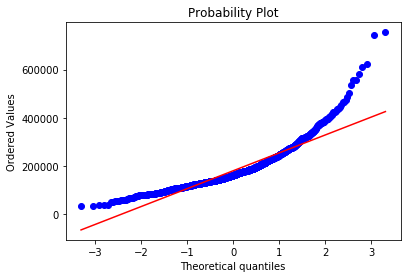

In [7]:
fig = plt.figure()
res = sp.stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

In [8]:
data_train["SalePrice"] = np.log1p(data_train["SalePrice"])

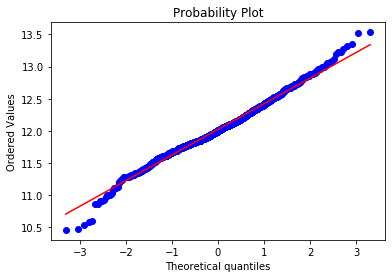

In [9]:
fig = plt.figure()
res = sp.stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

In [10]:
shape_train = data_train.shape[0]
shape_test = data_test.shape[0]
y_train = data_train.SalePrice.values
all_data = pd.concat((data_train, data_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [11]:
def Nan_data(data):
    nan_data = (data.isnull().sum() / len(data)) * 100
    return nan_data.drop(nan_data[nan_data == 0].index).sort_values(ascending=False)

In [12]:
Nan_data(all_data)

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageQual       5.450806
GarageCond       5.450806
GarageFinish     5.450806
GarageYrBlt      5.450806
GarageType       5.382242
BsmtExposure     2.811107
BsmtCond         2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtFullBath     0.068564
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
Electrical       0.034282
BsmtUnfSF        0.034282
Exterior1st      0.034282
Exterior2nd      0.034282
TotalBsmtSF      0.034282
GarageArea       0.034282
GarageCars       0.034282
BsmtFinSF2       0.034282
BsmtFinSF1       0.034282
KitchenQual      0.034282
SaleType         0.034282
dtype: float64

In [13]:
for col in ("PoolQC","MiscFeature", "Alley", "Fence","FireplaceQu", 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"MasVnrType"):
    all_data[col] = all_data[col].fillna('None')

In [14]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [15]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea"):
    all_data[col] = all_data[col].fillna(0)

In [16]:
all_data = all_data.drop(['Utilities'], axis=1)

In [17]:
for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [18]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [19]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [20]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [21]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [22]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [23]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'отклонение' :skewed_feats})

In [24]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [25]:
all_data = pd.get_dummies(all_data)

In [26]:
train = all_data[:shape_train]
test = all_data[shape_train:]

In [27]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [28]:
kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
sc = np.sqrt(-cross_val_score(model_lgb, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [29]:
print("\n{:.4f} ({:.4f})\n".format(sc.mean(), sc.std()))


0.1152 (0.0070)



In [30]:
model_lgb.fit(train.values,y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [31]:
pred=np.expm1(model_lgb.predict(test))

In [32]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)

In [33]:
model_lgb.score(train.values,y_train)

0.9665254587823939